In [ ]:
'''
Focuses on app_train only
'''

In [1]:
# imports
from utils import *
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

Training data shape:  (307511, 122)
Testing data shape:  (48744, 121)
ONE HOT ENCODED
Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)
ALIGNED:
Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)
There were 9274 anomalies in the test data out of 48744 entries
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 240)
Training Features shape:  (307511, 232)
Testing Features shape:  (48744, 231)


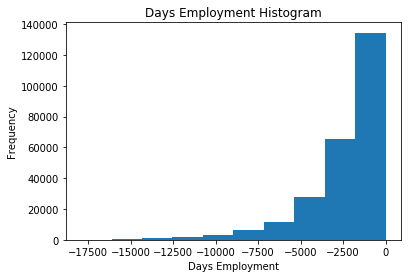

In [2]:
# do basic pre-processing
def pre_process():
    # read data
    train_data = load_training_data()
    test_data = load_test_data()
    train_data, test_data = encode_binary_cols(train_data, test_data)
    train_data, test_data = one_hot_encode(train_data, test_data)
    train_data, test_data, train_Y = align_data(train_data, test_data)
    train_data, test_data = remove_days_employed_anomaly(train_data, test_data)
    train_data, test_data = remove_missing_cols(train_data, test_data)
    return train_data, test_data

train_data, test_data = pre_process()

In [3]:
def get_train_test_set(train, test):
    train_Y = train['TARGET']
    try:
        train_X = train.drop(columns=['SK_CURR_ID'])
        train_X = train.drop(columns=['TARGET'])
        test_X = test.drop(columns=['SK_CURR_ID'])
    except Exception:
        pass
    return train_X, train_Y, test_X

In [ ]:
def gbm_basic(train_X, train_Y, test_X, feature_names, n_folds=5):
    print('Training Data Shape: ', train_X.shape)
    print('Testing Data Shape: ', test_X.shape)
    
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))

In [4]:
def get_top_correlations(df, feature, n=15):
    correlations = df.corr()[feature]
    correlations = abs(correlations).sort_values().tail(
        n)  # sort by correlation value (regardless if it's positive or negative)
    correlations = correlations.dropna()  # drop nans
    if 'TARGET' in correlations:
        correlations = correlations.drop(labels=[feature, 'TARGET'])  # remove corr to itself and target
    return correlations

# pcc_corrs = get_top_correlations(train_data, 'TARGET', n=15)

# save_pickle('../misc/target_corr_15_pcc.pickle', pcc_corrs)
pcc_corrs = load_pickle('../misc/target_corr_15_pcc.pickle')
print(pcc_corrs)


REG_CITY_NOT_WORK_CITY                  0.050994
DAYS_ID_PUBLISH                         0.051457
CODE_GENDER_F                           0.054704
CODE_GENDER_M                           0.054713
DAYS_LAST_PHONE_CHANGE                  0.055218
NAME_EDUCATION_TYPE_Higher education    0.056593
NAME_INCOME_TYPE_Working                0.057481
REGION_RATING_CLIENT                    0.058899
REGION_RATING_CLIENT_W_CITY             0.060893
DAYS_EMPLOYED                           0.074958
DAYS_BIRTH                              0.078239
EXT_SOURCE_1                            0.155317
EXT_SOURCE_2                            0.160472
EXT_SOURCE_3                            0.178919
Name: TARGET, dtype: float64


In [5]:
def impute(df):
    return df.fillna(df.mean())

train_imputed = impute(train_data)
test_imputed = impute(test_data)

In [10]:
from sklearn.preprocessing import PolynomialFeatures

def create_poly_feats(df, poly_cols, degree):
    # cols to create poly feature from
    selected_cols = df[poly_cols]
    # create polynomial features  to the given degree
    poly_transformer = PolynomialFeatures(degree=degree)
    poly_transformer.fit(selected_cols)
    poly_feats = poly_transformer.transform(selected_cols)
    
    # get the column names of the polynomial features
    col_names = poly_transformer.get_feature_names(poly_cols)
    poly_feats_df = pd.DataFrame(poly_feats, columns=col_names)
    poly_feats_df= poly_feats_df.drop(columns=['1']) #drop the constant column
    return poly_feats_df

def calc_poly_aic_score(feats_df, n=10):
    aic_scores = []
    # calculate the aic score for each of the poly features
    for col in feats_df:
        aic_scores.append(imputed_col_aic(feats_df, col))
    
    aic_df = pd.DataFrame({'col':feats_df.columns, 'aic':aic_scores}) 
    best_n_cols = get_top_aic_cols(aic_df, n)
    return aic_df, best_n_cols 

def get_top_aic_cols(df, n=10):
    # return the n features with the lowest aic score
    return df.sort_values(by='aic')[:n]['col'].values

# get the polynomial features for the training data
train_poly_df = create_poly_feats(train_imputed, pcc_corrs.keys()[-10:], 2)
train_poly_df['TARGET'] = train_imputed['TARGET'] # add Target col to train

# get the polynomial features for the testing
test_poly_df = create_poly_feats(test_imputed, pcc_corrs.keys()[-10:], 2)

# get the aic scores for each poly feature and the best features 
poly_aic_df, lowest_aic_cols = calc_poly_aic_score(train_poly_df, n=10)


Optimization terminated successfully.
         Current function value: 0.400406
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.575244
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.498391
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.304178
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.304496
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.351512
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.282745
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.280846
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.279522
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.274561
  

C:\Users\Bhumika\Anaconda3\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [52]:
train_poly = train_poly_df[lowest_aic_cols] #top poly feature df
test_poly = test_poly_df[lowest_aic_cols] #top poly feature df

# Merge polynomial features into training dataframe
print(train_data.shape, test_data.shape)
train_poly['SK_ID_CURR'] = train_data['SK_ID_CURR']
train_poly = train_data.merge(train_poly, on = 'SK_ID_CURR', how = 'left')

#  Merge polynomial features into testing dataframe
test_poly['SK_ID_CURR'] = test_data['SK_ID_CURR']
test_poly = test_data.merge(test_poly, on = 'SK_ID_CURR', how = 'left')

print(train_poly.shape, test_poly.shape)

(307511, 232) (48744, 231)
(307511, 242) (48744, 241)


In [53]:
set(train_poly.columns).difference(set(test_poly.columns))
# 'TARGET' in train_poly

{'TARGET'}